
- Name: Snehal Awadan
- PRN : 240340128033
- Date: 02-06-2024

# Deep Neural Network

## Assignment A06 : 
## Working with PyTorch
- Custom DataSet with common transformation
- ${swish}$ activation function
- Regularizations:
    - L2, 
    - BatchNorm,
    - Dropout, 
    - Early Stopping
    
- multi-class output
- FIFA dataset 

## 1.1 Import Libraries

In [1]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np 
import pandas as pd 

#from collections.abc import Callable
#from typing import Literal

from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, classification_report 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay 
from sklearn.preprocessing import StandardScaler 

import matplotlib.pyplot as plt 
import torch.nn.functional as F
import torch
import torch.nn as nn 
import torch 
from torch.utils.data import Dataset, DataLoader 
#from pytorch_lightning.callbacks import EarlyStopping




## 1.2 Set Hyper Parameters

In [2]:
###----------------------
### Some basic parameters
###----------------------

inpDir = '../../input'
outDir = '../output'
modelDir = '../models'
subDir = 'fifa_2019'
modelSubDir = 'fifa2019'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
torch.manual_seed(RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 100 # number of epochs
BATCH_SIZE = 256
ALPHA = 0.001 # learning rate
TEST_SIZE = 0.2

## Tolerance for loss, min change required
MIN_TOLERANCE = 0.0001
# L2 regularizer
WEIGHT_DECAY = 0.001
## patience
PATIENCE = 10
LR_FACTOR = 0.1     ## Learning Rate Factor
LR_PATIENCE = 10 ## LR_patience

# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 10),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params)

## 1.3 All about CUDA

In [4]:
# ## check whether cuda is available
# print ('Is CUDA available: ', torch.cuda.is_available())
# if torch.cuda.is_available():
#     print ('CUDA version: ', torch.version.cuda )
#     print ('Current Device ID: ', torch.cuda.current_device())
#     print ('Name of the CUDA device: ', torch.cuda.get_device_name(torch.cuda.current_device()))
#     print ('Number of CUDA devices: ', torch.cuda.device_count())

# ### device
# device = "cuda" if torch.cuda.is_available() else "cpu"
# print(f"Using {device} device")

## 1.4 Helper functions

In [5]:
###------------------------------
### Plot Loss Curve using pytorch
###------------------------------
def fn_plot_torch_hist(hist_df):
    
    # instantiate figure
    fig, axes = plt.subplots(1,2 , figsize = (15,6))
    
    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='cyan', alpha=0.5)

    # columns
    x = hist_df.columns[0]
    y1 = hist_df.columns[1]
    y2 = hist_df.columns[2]
    y3 = hist_df.columns[3]
    y4 = hist_df.columns[4]
    
    # Where was min loss
    best = hist_df[hist_df[y2] == hist_df[y2].min()]
    best = best.drop_duplicates(subset=y2)
    # pick first axis
    ax = axes[0]

    # Plot all losses
    hist_df.plot(x = x, y = [y1, y2], ax = ax)

    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y2].min())
    y_max = max(hist_df[y1].max(), hist_df[y2].max())
    offset = (y_max-y_min)/10.0

    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y2]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y2].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y2].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()+ offset, best[y2].to_numpy()[0]+offset), # location of text 
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow
    
    # Draw vertical line at best value
    ax.axvline(x = best[x].to_numpy(), color = 'green', linestyle='-.', lw = 3);
    
    ax.set_xlabel(x.title())
    ax.set_ylabel(y1.title())
    ax.set_title('Errors')
    ax.grid()
    ax.legend(loc = 'upper left') # model legend to upper left

    # pick second axis
    ax = axes[1]

    # Plot accuracies
    hist_df.plot(x = x, y = [y3, y4], ax = ax)

    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y3],
                           hist_df.iloc[-1][y4]) #text to plot
        
    # calculate offset for arroe
    y_min = min(hist_df[y3].min(), hist_df[y4].min())
    y_max = max(hist_df[y3].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # place a text box in lower middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()- offset, best[y4].to_numpy()[0]-offset), # location of text 
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow
    
    
    # Draw a vertical line at best value
    ax.axvline(x = best[x].to_numpy(), 
               color = 'green', 
               linestyle='-.', lw = 3)
    
    # Labels
    ax.set_xlabel(x.title())
    ax.set_ylabel(y3.title())
    ax.set_title('Accuracies')
    ax.grid();
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()




###----------------------
### Plot confusion matrix
###----------------------
def fn_plot_confusion_matrix(y_true, y_pred, labels):
    '''
    Args:
        y_true: Ground Truth 
        y_pred : Predictions
        labels : dictonary 
                  {0: 'Goal Keeper', 
                  1: 'Defender', 
                  2: 'Mid-Fielder', 
                  3: 'Forward'}
    
    '''
    
    cm  = confusion_matrix(y_true, y_pred)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=labels.values())
    
    fig, ax = plt.subplots(figsize = (6,6))
    
    disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)
    # Disable the grid
    ax.grid(False)

    plt.show();

In [6]:
# check helper function documentation
print(fn_plot_torch_hist.__doc__)
print (fn_plot_confusion_matrix.__doc__)

None

    Args:
        y_true: Ground Truth 
        y_pred : Predictions
        labels : dictonary 
                  {0: 'Goal Keeper', 
                  1: 'Defender', 
                  2: 'Mid-Fielder', 
                  3: 'Forward'}
    
    


## 1.5 Basic Hygiene

In [8]:
# # Check if all directories are present
# if not os.path.exists(os.path.join(outDir)):
#     os.makedirs(os.path.join(outDir))
#     print ('Created {} directory'.format(outDir))

# if not os.path.exists(os.path.join(modelDir, subDir)):
#     os.makedirs(os.path.join(modelDir, subDir))
#     print ('Created {} directory'.format(os.path.join(modelDir, subDir)))

## 2.1 Read data into pandas DataFrame

In [12]:

data_df = pd.read_csv('fifa_2019.csv', index_col = 0)

print(data_df.shape)

data_df.head()

(18207, 88)


,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,https://cdn.sofifa.org/teams/2/light/241.png,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,https://cdn.sofifa.org/teams/2/light/45.png,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,https://cdn.sofifa.org/teams/2/light/73.png,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,https://cdn.sofifa.org/teams/2/light/11.png,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,https://cdn.sofifa.org/teams/2/light/10.png,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [13]:
# Following columns appear to be relevant for our analysis

rel_cols = ["Position", 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
            'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
            'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
            'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
            'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
            'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
            'GKKicking', 'GKPositioning', 'GKReflexes']

In [14]:
goalkeeper = 'GK'
forward = ['ST', 'LW', 'RW', 'LF', 'RF', 'RS','LS', 'CF']
midfielder = ['CM','RCM','LCM', 'CDM','RDM','LDM', 'CAM', 'LAM', 'RAM', 'RM', 'LM']
defender = ['CB', 'RCB', 'LCB', 'LWB', 'RWB', 'LB', 'RB']

### 2.1.1 Data cleaning and preprocessing

In [15]:
# removing rows with position = null
data_df = data_df[data_df["Position"].notnull()]
data_df.head()

,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,https://cdn.sofifa.org/teams/2/light/241.png,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,https://cdn.sofifa.org/teams/2/light/45.png,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,https://cdn.sofifa.org/teams/2/light/73.png,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,https://cdn.sofifa.org/teams/2/light/11.png,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,https://cdn.sofifa.org/teams/2/light/10.png,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [16]:
#Assign labels to goalkeepers
data_df.loc[data_df["Position"] == "GK", "Position"] = 0

#Defenders
data_df.loc[data_df["Position"].isin(defender), "Position"] = 1

#Midfielders
data_df.loc[data_df["Position"].isin(midfielder), "Position"] = 2

#Forward
data_df.loc[data_df["Position"].isin(forward), "Position"] = 3

# Convert Column "Position" to numeric so that Pandas does not complain
data_df['Position'] = pd.to_numeric(data_df['Position'], downcast="integer")

In [17]:
class_labels = {0: 'Goal Keeper', 1: 'Defender', 2: 'Mid-Fielder', 3: 'Forward'}
data_df = data_df[rel_cols]
display(data_df.head())

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,3,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,3,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,3,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,2,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [18]:
# splitting in train ans test datasets
train_df, test_df = train_test_split(data_df,
                                     stratify=data_df['Position'],
                                     test_size=TEST_SIZE, 
                                     random_state=RANDOM_STATE )
train_df.shape, test_df.shape

((14517, 34), (3630, 34))

In [19]:
## check dataset
print("============== Train Data ==================")
print(train_df.shape)
display(train_df.head())
print("============== Test Data ==================")
print(test_df.shape)
display(test_df.head())

============== Train Data ==================
(14517, 34)


,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
14537,3,62.0,57.0,51.0,47.0,61.0,42.0,27.0,41.0,59.0,...,63.0,52.0,21.0,16.0,12.0,11.0,7.0,10.0,12.0,11.0
13946,3,55.0,42.0,58.0,60.0,62.0,61.0,56.0,52.0,60.0,...,60.0,53.0,29.0,25.0,22.0,7.0,12.0,6.0,9.0,10.0
11680,2,56.0,36.0,61.0,51.0,69.0,60.0,52.0,57.0,66.0,...,54.0,50.0,23.0,22.0,27.0,12.0,10.0,9.0,9.0,14.0
4935,0,11.0,12.0,35.0,12.0,12.0,22.0,13.0,40.0,20.0,...,20.0,60.0,11.0,10.0,15.0,69.0,70.0,66.0,67.0,73.0
7840,2,66.0,44.0,66.0,48.0,70.0,74.0,75.0,62.0,67.0,...,76.0,60.0,40.0,38.0,28.0,14.0,12.0,6.0,12.0,12.0


============== Test Data ==================
(3630, 34)


,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
1697,2,66.0,33.0,72.0,55.0,81.0,69.0,65.0,61.0,79.0,...,57.0,68.0,23.0,26.0,30.0,12.0,14.0,16.0,6.0,10.0
3351,2,71.0,43.0,68.0,43.0,72.0,74.0,69.0,70.0,78.0,...,64.0,66.0,39.0,26.0,16.0,14.0,14.0,13.0,6.0,8.0
13000,2,67.0,43.0,61.0,49.0,65.0,48.0,35.0,44.0,65.0,...,54.0,47.0,49.0,13.0,19.0,9.0,12.0,15.0,12.0,13.0
12047,2,55.0,37.0,69.0,45.0,67.0,50.0,51.0,64.0,62.0,...,53.0,61.0,55.0,61.0,57.0,13.0,7.0,10.0,8.0,12.0
1377,1,25.0,82.0,61.0,20.0,51.0,25.0,33.0,63.0,60.0,...,42.0,67.0,77.0,78.0,70.0,15.0,12.0,13.0,14.0,15.0


## 2.2 Data Preparation

In [20]:
''' Using Singleton design pattern '''


class GlobalScalar:
    _instance = None
    def __init__(self):
        if GlobalScalar._instance is not None:
            raise Exception("Global class is a singleton!")
        self.scalar = StandardScaler()

    @classmethod
    def get_instance(cls):
        if cls._instance is None:
            cls._instance = GlobalScalar()
        return cls._instance
    
    def scale(self,X):
        return self.scalar.transform(X)


class FifaDS(Dataset):
    globalScalar = GlobalScalar.get_instance() # private instance
    def __init__(self,
                 dataFrame = pd.DataFrame,
                 device : str = device,
                 is_train = True,
                 label_col = None
                 ):
        self.df = dataFrame
        self.device = device
        self.is_train = is_train
        self.scalar = self.globalScalar.scalar
        self.label_col = label_col

        self.labels = self.df[label_col].to_numpy()
        X = self.df.drop(label_col, axis = 1)
        #self.X = X.to_numpy()

        if self.is_train:
            self.features = self.scalar.fit_transform(X)
        else:
            self.features = self.scalar.transform(X) # transform 
            
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, index):
        # extract features and labels from the dataFrame row
        #X = self.features[index]

        features = self.features[index]
        label = self.labels[index]

        # convert tot PyTorch tensors
        features = torch.tensor(features,
                                dtype= torch.float32,
                                device = self.device)
        label = torch.tensor(label,
                             dtype=torch.int64,
                             device = self.device)
        return features, label
        

### 2.2.1 DataSets

In [21]:
train_df = train_df.reset_index(drop=True)
train_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,3,62.0,57.0,51.0,47.0,61.0,42.0,27.0,41.0,59.0,...,63.0,52.0,21.0,16.0,12.0,11.0,7.0,10.0,12.0,11.0
1,3,55.0,42.0,58.0,60.0,62.0,61.0,56.0,52.0,60.0,...,60.0,53.0,29.0,25.0,22.0,7.0,12.0,6.0,9.0,10.0
2,2,56.0,36.0,61.0,51.0,69.0,60.0,52.0,57.0,66.0,...,54.0,50.0,23.0,22.0,27.0,12.0,10.0,9.0,9.0,14.0
3,0,11.0,12.0,35.0,12.0,12.0,22.0,13.0,40.0,20.0,...,20.0,60.0,11.0,10.0,15.0,69.0,70.0,66.0,67.0,73.0
4,2,66.0,44.0,66.0,48.0,70.0,74.0,75.0,62.0,67.0,...,76.0,60.0,40.0,38.0,28.0,14.0,12.0,6.0,12.0,12.0


In [22]:
test_df = test_df.reset_index(drop=True)
test_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,2,66.0,33.0,72.0,55.0,81.0,69.0,65.0,61.0,79.0,...,57.0,68.0,23.0,26.0,30.0,12.0,14.0,16.0,6.0,10.0
1,2,71.0,43.0,68.0,43.0,72.0,74.0,69.0,70.0,78.0,...,64.0,66.0,39.0,26.0,16.0,14.0,14.0,13.0,6.0,8.0
2,2,67.0,43.0,61.0,49.0,65.0,48.0,35.0,44.0,65.0,...,54.0,47.0,49.0,13.0,19.0,9.0,12.0,15.0,12.0,13.0
3,2,55.0,37.0,69.0,45.0,67.0,50.0,51.0,64.0,62.0,...,53.0,61.0,55.0,61.0,57.0,13.0,7.0,10.0,8.0,12.0
4,1,25.0,82.0,61.0,20.0,51.0,25.0,33.0,63.0,60.0,...,42.0,67.0,77.0,78.0,70.0,15.0,12.0,13.0,14.0,15.0


In [23]:
label_col = 'Position'
train_ds = FifaDS(train_df, is_train=True, label_col=label_col)
test_ds = FifaDS(test_df, is_train=False, label_col=label_col)

In [24]:
input_shape = train_df.shape[1] - 1
input_shape

33

### 2.2.2 DataSet Loader 

In [25]:
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True)

In [26]:
### Sanity check 
features, labels = next(iter(train_loader))
features.shape, labels.shape

(torch.Size([256, 33]), torch.Size([256]))

## 3.1 Prepare Model

In [27]:
# Swish Function 

class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)


In [28]:

class Model(nn.Module):
    
    def __init__(self, input_dim):
        super(Model, self).__init__()
        
        # define dropOut rates
    
        self.dor1 = 0.7    # dropout rate

        self.layer1 = nn.Linear(input_dim,16)
        self.bn1 = nn.BatchNorm1d(16)  # Add Batch Normalization
        self.active1 = Swish()
        self.dropout1 = nn.Dropout(self.dor1)
        self.layer2 = nn.Linear(16, 4)
        
    def forward(self, x):
        x = F.tanh(self.layer1(x))
        x = self.bn1(x)
        x = self.active1(x)
        x = self.dropout1(x)  # dropout layer 
        x = F.softmax(self.layer2(x), dim = 1)
        return x



model = Model(input_dim=train_df.shape[1]-1).to(device) # Create model on GPU
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=ALPHA, weight_decay=WEIGHT_DECAY)


Model(
  (layer1): Linear(in_features=33, out_features=16, bias=True)
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (active1): Swish()
  (dropout1): Dropout(p=0.7, inplace=False)
  (layer2): Linear(in_features=16, out_features=4, bias=True)
)


In [29]:
train_df.shape[1]-1

33

## 3.2 Training model

In [34]:
# Define the loss function and optimizer

loss_fn = nn.CrossEntropyLoss() # cross entropy loss
loss, testLoss = [],[]
acc, testAcc = [],[]
n_epoch = []


# Train the model for multiple epochs
counter = 0
minLoss = float('inf')  # minimum loss # to implement early stopping
for epoch in range(EPOCHS):
    
    # Training loop
    train_loss = 0.0
    verbose=2
    train_acc = 0.0

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                            factor=LR_FACTOR,
                                                            patience=LR_PATIENCE,                                                            
                                                            mode='min',
                                                            min_lr=0.00001)    
    savePath = os.path.join(modelDir, subDir, 'fifa_v1.pth') #
    
    for i, data in enumerate(train_loader):
        model.train()
        # Training loop
      
        inputs, labels = data
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        
        preds = torch.argmax(outputs, dim = 1)
        
        batch_loss = loss_fn(outputs, labels)
        batch_acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
        
        batch_loss.backward()
        
        optimizer.step()
        
        train_loss += batch_loss.item() * inputs.size(0)
        train_acc += batch_acc * inputs.size(0)
    
    train_loss /= len(train_ds)
    train_acc /= len(train_ds)
    
    loss.append(train_loss)
    acc.append(train_acc)
    
    # Testing loop
    test_loss = 0.0
    test_acc = 0.0
    
    with torch.no_grad():
        
        for data in test_loader:
            model.eval()
            # Training loop
            #test_loss = 0.0
            #test_acc = 0.0
            
            inputs, labels = data
            
            outputs = model(inputs)
            
            preds = torch.argmax(outputs, dim = 1)
            
            batch_loss = loss_fn(outputs, labels)

            batch_acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
            
            test_loss += batch_loss.item() * inputs.size(0)
            test_acc += batch_acc* inputs.size(0)
        
        test_loss /= len(test_ds)
        test_acc /= len(test_ds)
    
        testLoss.append(test_loss)
        testAcc.append(test_acc)
    n_epoch.append(epoch)
    ## steps for schedular
    # transformers.encoder.__dict__['classes_']
    scheduler.step(test_loss)
    ##################################
    #### Alpha for Early stopping ####
    ##################################
    

    #print(minLoss, test_loss)
    if (test_loss < minLoss):
        
        if (abs(test_loss - minLoss) > MIN_TOLERANCE):
            counter = 0            
        else:
            counter +=1
        minLoss = test_loss
        
        
        
       
        # save the model 
        torch.save({'epoch':epoch+1,
                    'model_state_dict':model.state_dict(),
                    'optimizer_state_dict':optimizer.state_dict(),
                    'loss': loss_fn}, savePath)
    else:
        counter += 1
    if counter > PATIENCE:
        print("Early Stopping")        
        break;
        ##################################
    



    
    #if epoch%5 == 0:
    print(f'At epoch {epoch}', end='    ')
    print(f'Loss - train:{train_loss:.4f}',end='    ')
    print(f'test:{test_loss:.4f}', end ='   ')
    print(f'Accuracy - train:{train_acc:.4f}, test:{test_acc:.4f}',end='    ')
    print(f'counter:{counter}')

At epoch 0    Loss - train:1.3097    test:1.2223   Accuracy - train:0.4031, test:0.7333    counter:0
At epoch 1    Loss - train:1.1989    test:1.1078   Accuracy - train:0.6572, test:0.7959    counter:0
At epoch 2    Loss - train:1.1224    test:1.0250   Accuracy - train:0.7338, test:0.8163    counter:0
At epoch 3    Loss - train:1.0770    test:0.9759   Accuracy - train:0.7557, test:0.8298    counter:0
At epoch 4    Loss - train:1.0478    test:0.9469   Accuracy - train:0.7715, test:0.8399    counter:0
At epoch 5    Loss - train:1.0235    test:0.9290   Accuracy - train:0.7839, test:0.8463    counter:0
At epoch 6    Loss - train:1.0109    test:0.9166   Accuracy - train:0.7889, test:0.8477    counter:0
At epoch 7    Loss - train:0.9963    test:0.9083   Accuracy - train:0.7949, test:0.8510    counter:0
At epoch 8    Loss - train:0.9900    test:0.9030   Accuracy - train:0.8000, test:0.8507    counter:0
At epoch 9    Loss - train:0.9795    test:0.8999   Accuracy - train:0.8031, test:0.8515    

## 3.3 Saving weights and model


In [35]:
# savePath = os.path.join(modelDir, subDir, 'fifa.pth') 
# torch.save({'epoch':epoch+1,
#                         'model_state_dict':model.state_dict(),
#                         'optimizer_state_dict':optimizer.state_dict(),
#                         'loss': loss_fn}, savePath)

In [36]:
loss_df = pd.DataFrame({'epoch': n_epoch,
                       'loss' : loss,
                       'test_loss' : testLoss,
                       'acc' : acc,
                       'test_acc': testAcc})
display(loss_df)



,epoch,loss,test_loss,acc,test_acc
0,0,1.309734,1.222312,0.403114,0.733333
1,1,1.198891,1.107775,0.657161,0.795868
2,2,1.122409,1.025004,0.733829,0.816253
3,3,1.076968,0.975883,0.755666,0.829752
4,4,1.047755,0.946915,0.771509,0.839945
...,...,...,...,...,...
58,58,0.925321,0.882904,0.834952,0.861433
59,59,0.923843,0.881520,0.837501,0.861708
60,60,0.925891,0.881870,0.834883,0.864463
61,61,0.924360,0.881336,0.837225,0.864738


### 3.3.1 Visualize loss curve

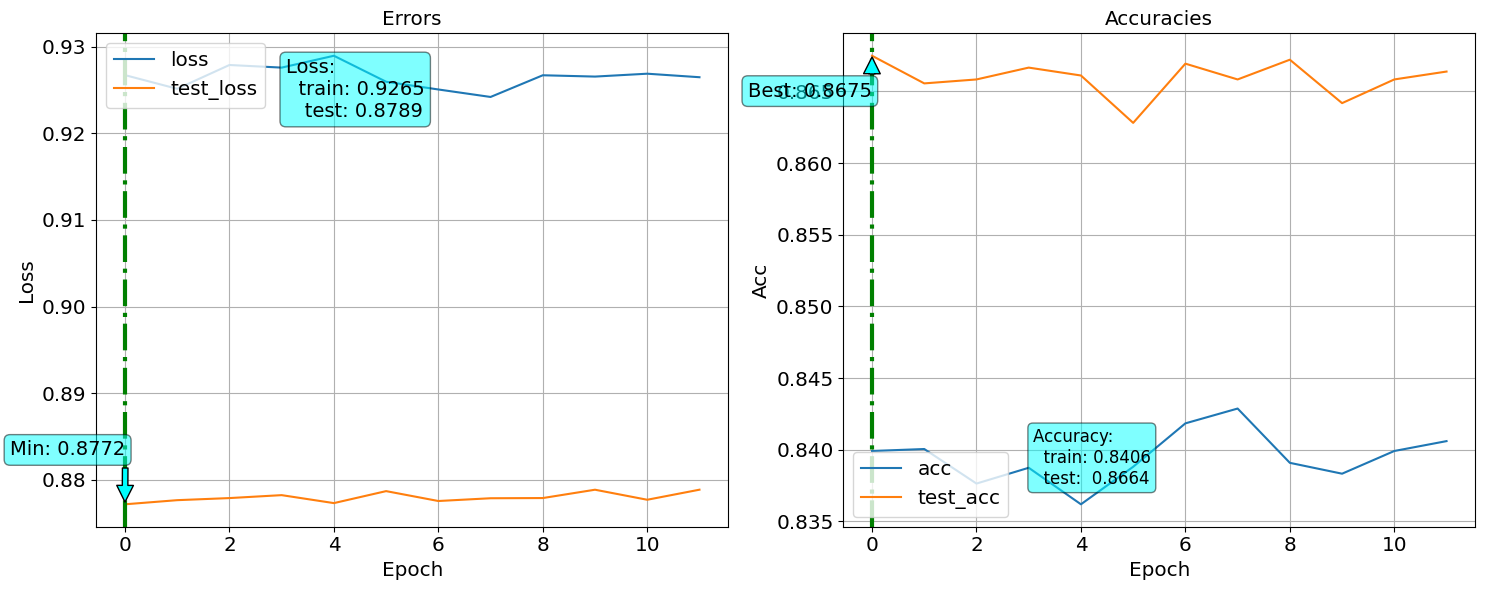

In [30]:
fn_plot_torch_hist(loss_df)

## 4.1 Model Evaluation

### 4.1.1 Performance on Train Data

In [31]:
y_train = []
y_pred = []

## loop over all train set
for i, data in enumerate(train_loader):    
    inputs, labels = data    
    outputs = model(inputs)    
    preds = torch.argmax(outputs, dim = 1)
    y_train.extend(labels.cpu().numpy())
    y_pred.extend(preds.cpu().numpy())

print(classification_report(y_train,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1620
           1       0.90      0.92      0.91      4693
           2       0.83      0.85      0.84      5470
           3       0.85      0.79      0.82      2734

    accuracy                           0.88     14517
   macro avg       0.90      0.89      0.89     14517
weighted avg       0.88      0.88      0.88     14517



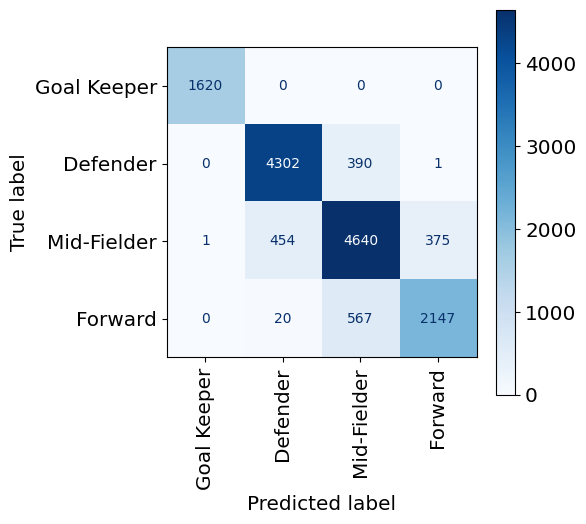

In [32]:
#class_labels = {0: 'Goal Keeper', 1: 'Defender', 2: 'Mid-Fielder', 3: 'Forward'}
cm  = confusion_matrix(y_train, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_labels.values())
fig, ax = plt.subplots(figsize = (5,5))
plt.grid(False)
disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=True)
plt.show();

### 4.1.2 Performance on Test Data

In [33]:
y_test = []
y_pred = []
## loop over all train set
for i, data in enumerate(test_loader):    
    inputs, labels = data    
    outputs = model(inputs)    
    preds = torch.argmax(outputs, dim = 1)
    y_test.extend(labels.cpu().numpy())
    y_pred.extend(preds.cpu().numpy())

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       405
           1       0.90      0.92      0.91      1173
           2       0.82      0.84      0.83      1368
           3       0.82      0.75      0.79       684

    accuracy                           0.87      3630
   macro avg       0.89      0.88      0.88      3630
weighted avg       0.87      0.87      0.87      3630



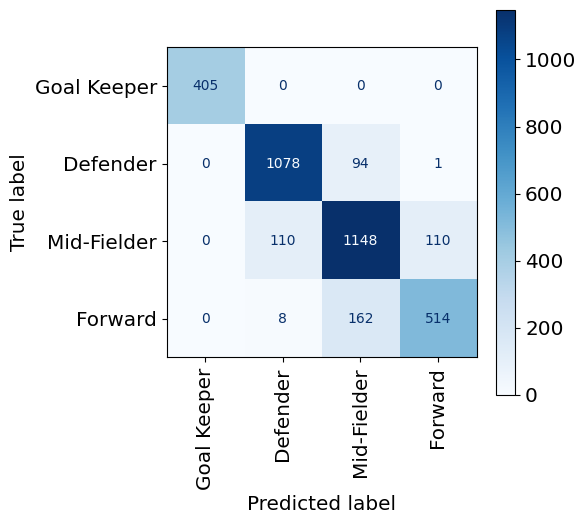

In [34]:
#class_labels = {0: 'Goal Keeper', 1: 'Defender', 2: 'Mid-Fielder', 3: 'Forward'}
cm  = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_labels.values())
fig, ax = plt.subplots(figsize = (5,5))
plt.grid(False)
disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=True)
plt.show();

## Observations
1. Base Model using Swish Function
2. With L2 Regularization
3. Dropouts with various values
4. Batch Normalization
5. Early Stopping        





## 1. Base Model Using Swish (SiLU) function 
- EPOCHS = 100 
- BATCH_SIZE = 256
- ALPHA = 0.001 # learning rate
- Accuracy on Train Set : 0.8691
- Accuracy on Test Set  : 0.8672


![Base Model using Swish as activation function](images/basemodel.png)

## 2. With L2 Regularization
- EPOCHS = 100 
- BATCH_SIZE = 256
- ALPHA = 0.001 # learning rate
- WEIGHT_DECAY = 0.001
- Accuracy on Train Set : 0.9036
- Accuracy on Test Set  : 0.8796



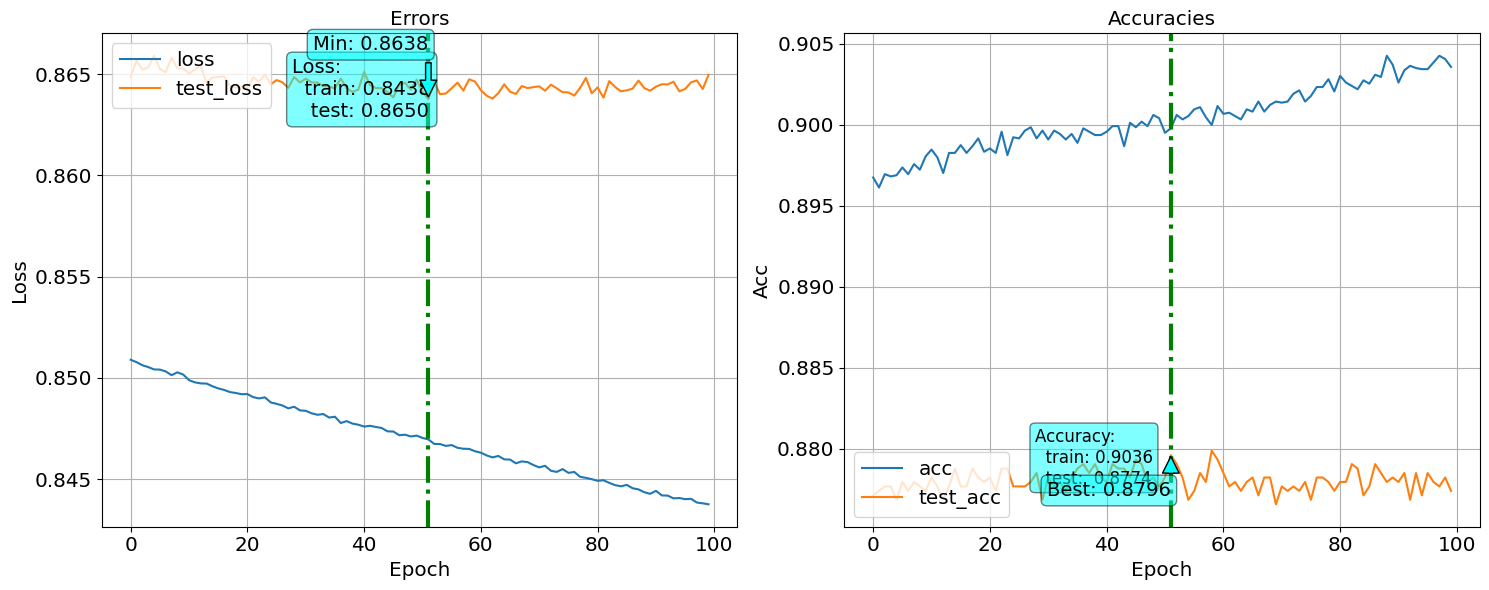


## 3. Dropouts with various values
- EPOCHS = 100 
- BATCH_SIZE = 256
- ALPHA = 0.001 # learning rate
- WEIGHT_DECAY = 0.001



### 1. dropout = 0.3
- Accuracy on Train Set : 0.8689
- Accuracy on Test Set  : 0.8686


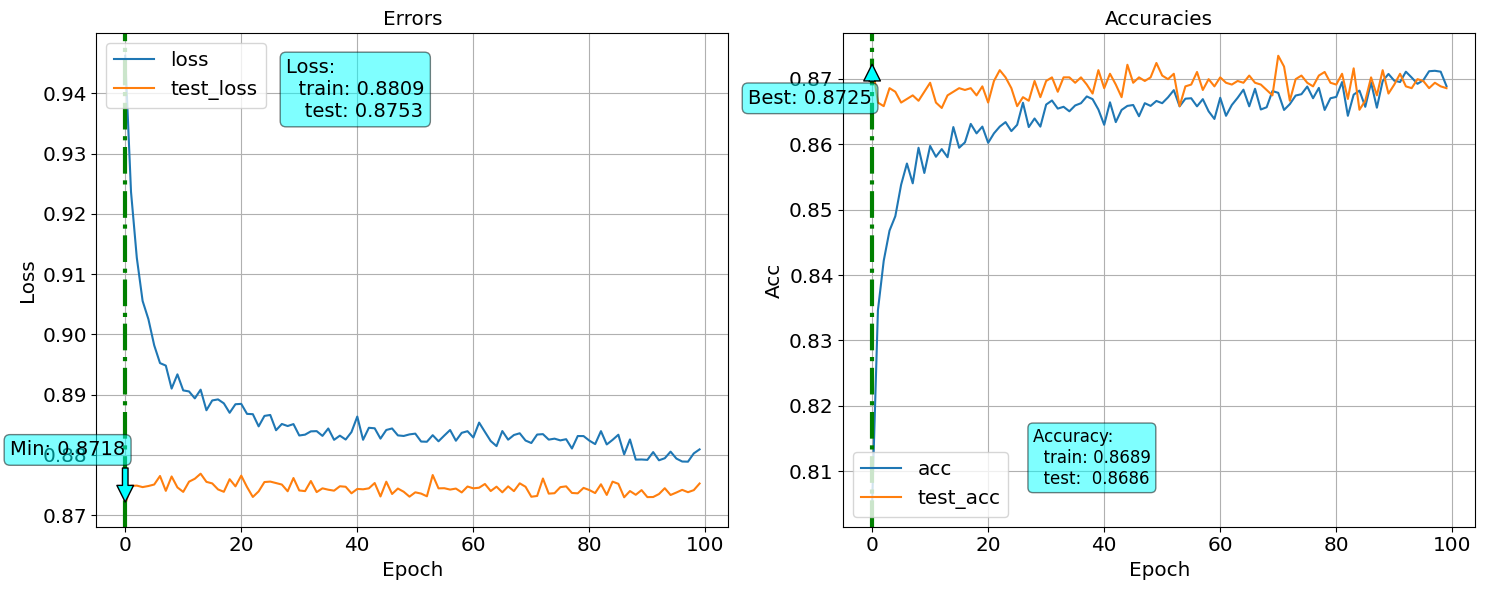

### 2. dropout = 0.5
- Accuracy on Train Set : 0.8619
- Accuracy on Test Set  : 0.8645


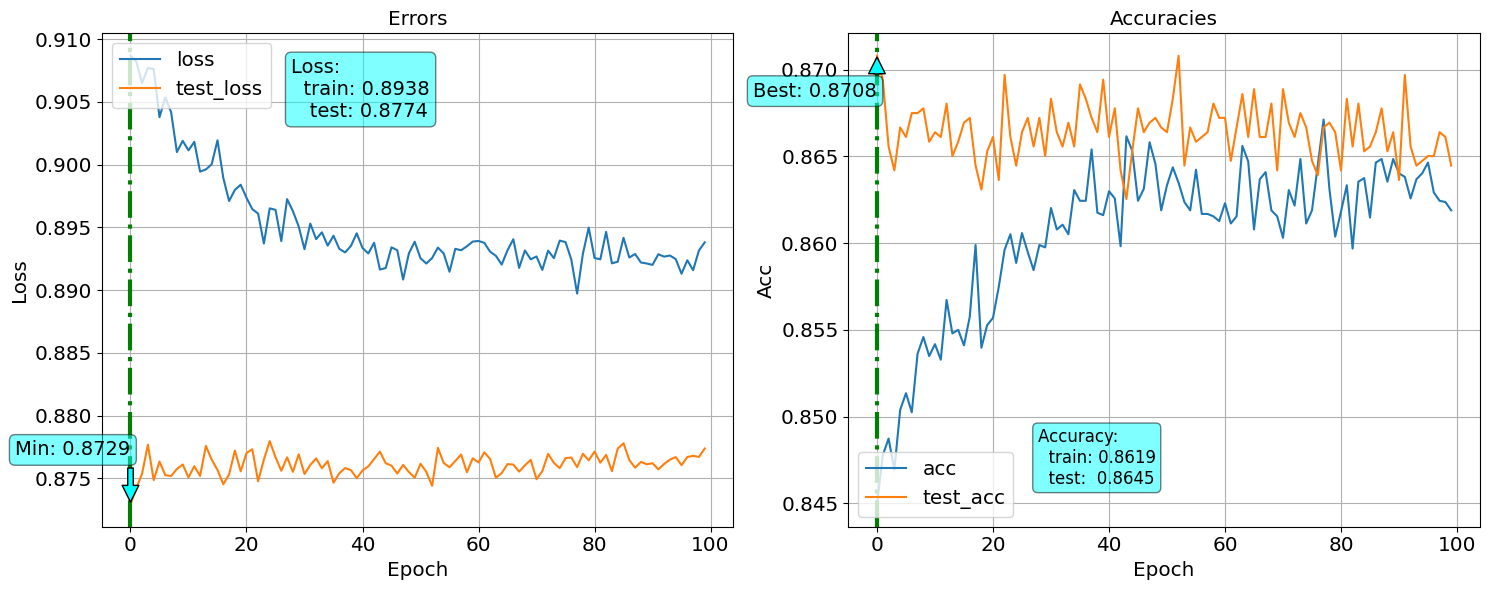

### 3. dropout = 0.7
- Accuracy on Train Set : 0.8375
- Accuracy on Test Set  : 0.8653


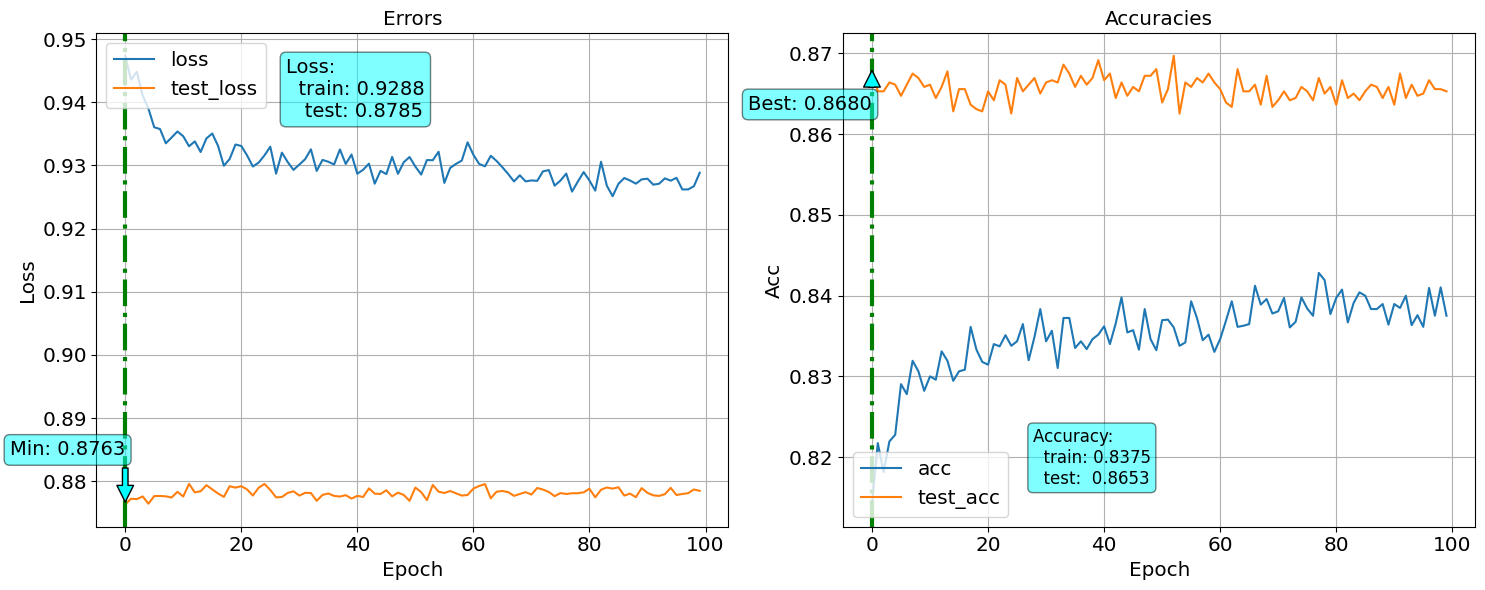

## 4. Batch Normalization
- EPOCHS = 100 
- BATCH_SIZE = 256
- ALPHA = 0.001 # learning rate
- WEIGHT_DECAY = 0.001
- Adding a batchnormalization layer after first layer
- Accuracy on Train Set : 0.8877
- Accuracy on Test Set  : 0.8752


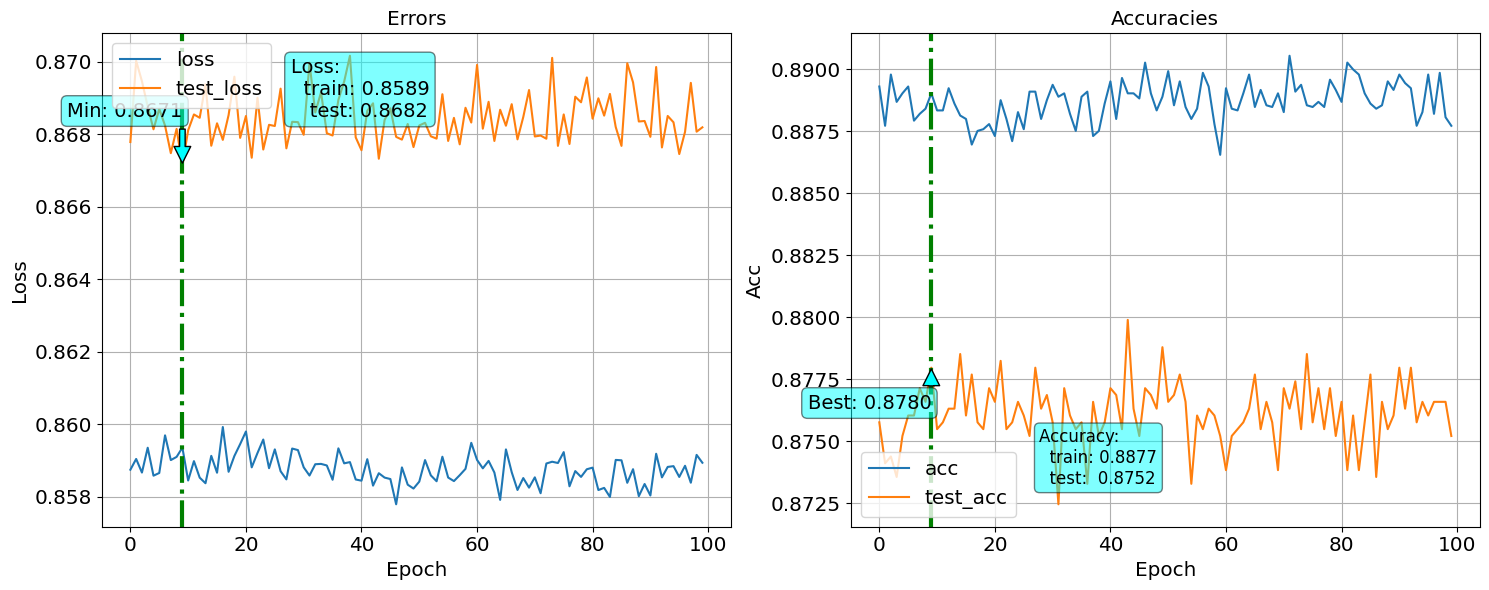

## 5. Early Stopping
- EPOCHS = 100 
- BATCH_SIZE = 256
- ALPHA = 0.001 # learning rate
- WEIGHT_DECAY = 0.001
- Adding a batchnormalization layer after first layer
- MIN_TOLERANCE = 0.0001 value, is used to monitor validation loss
- Accuracy on Train Set : 0.8390
- Accuracy on Test Set  : 0.8678



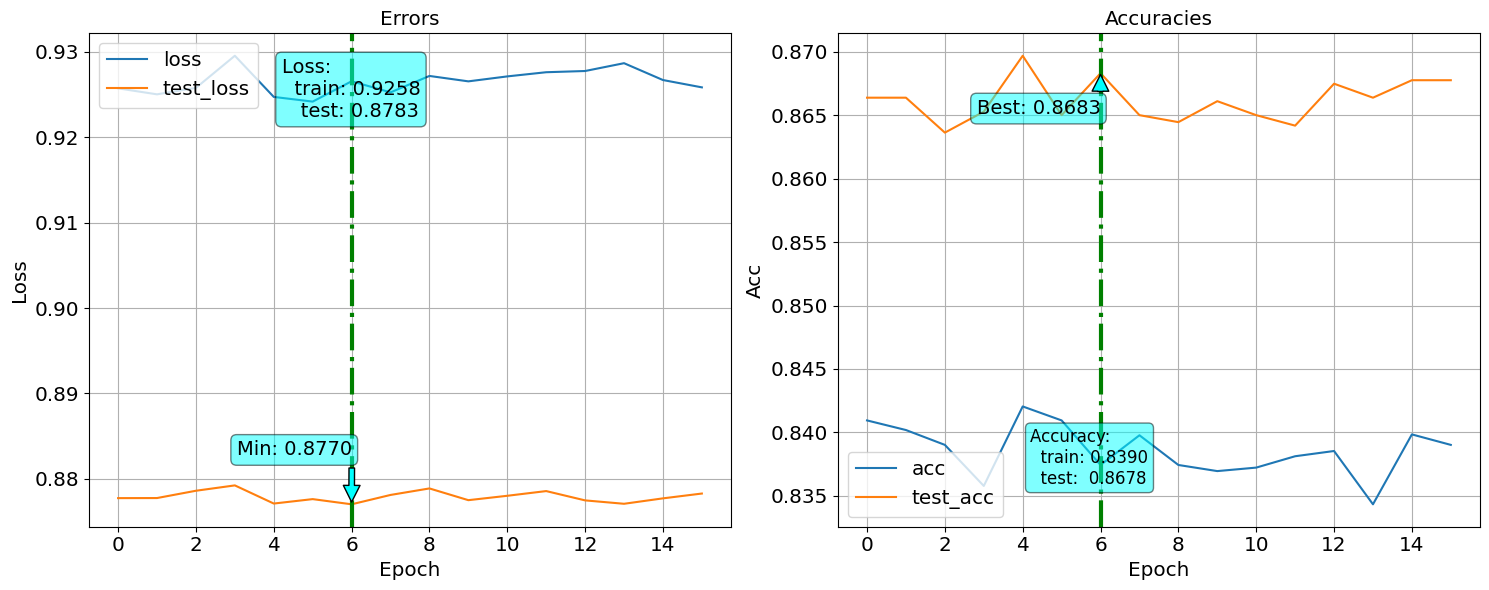